In [1]:
import sys
from scipy.special import sph_harm
import numpy as np
import matplotlib.pyplot as plt

from pynhhd import nHHD

def gradient(sfield, lat, lon, dx, r=6371E3, rotated=False, glob=True):
    '''
    gradient on a sphere 
    '''
    if glob:
        ddy = np.gradient(sfield, np.radians(dx[0]), axis=0)/r
        ddx = np.gradient(sfield, np.radians(dx[1]), axis=1)/(r*np.cos(np.radians(lat)))
        ddx[:,0] = np.gradient(np.concatenate([sfield[:,-1:],sfield[:,:2]],axis=1), np.radians(dx[1]), axis=1)[:,1]/(r*np.cos(np.radians(lat[:,0])))
        ddx[:,-1] = np.gradient(np.concatenate([sfield[:,-2:],sfield[:,:1]],axis=1), np.radians(dx[1]), axis=1)[:,1]/(r*np.cos(np.radians(lat[:,0])))
    else:
        ddy = np.gradient(sfield, np.radians(dx[0]), axis=0)/r
        ddx = np.gradient(sfield, np.radians(dx[1]), axis=1)/(r*np.cos(np.radians(lat)))
        
    if rotated:
        grad = np.stack((-ddy, ddx), axis=-1)
    else:
        grad = np.stack((ddx, ddy), axis = -1)
    
    return grad

In [2]:
plotpath = ''
savefigs = False

# CREATE GLOBAL 1 DEG GRID
dlon=dlat=1.0
lon, lat = np.meshgrid(np.arange(-180+dlon,180,dlon).astype(np.float64),np.arange(-90+dlat,90,dlat).astype(np.float64))
lon2=lon.copy()
lat2=lat.copy()+90
lon2[np.where(lon2<0)]=lon2[np.where(lon2<0)]+360

# CREATE IDEALIZED STREAMFUNCTION AND VELOCITY POTENTIALS USING SPHERICAL HARMONICS
r   = 6371E3
psi = r*np.real(sph_harm(3,5,np.radians(lon2),np.radians(lat2[::-1]))) # stream function
phi = r*np.real(sph_harm(3,5,np.radians(lon2),np.radians(lat2[::-1]))) # velocity potential

#
r0 = gradient(psi, lat, lon,[dlat,dlon], r=r, rotated=True, glob=True)
d0 = gradient(phi, lat, lon,[dlat,dlon], r=r, rotated=False, glob=True)

#
U = r0[:,:,0]+d0[:,:,0]
V = r0[:,:,1]+d0[:,:,1]

     Computing gradient...
True (1.0, 1.0) 6371000.0
nan nan
 Done!


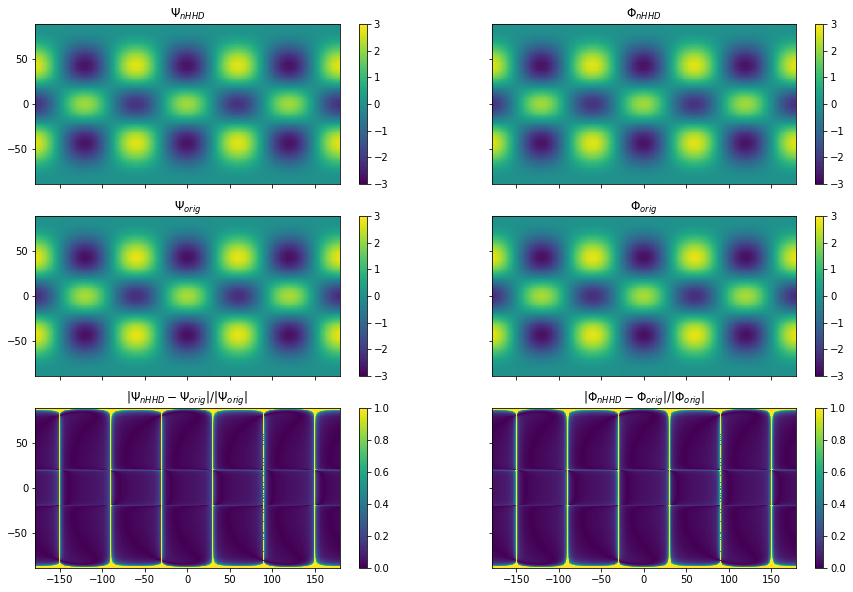

In [3]:
###############################
# TEST 1 - GLOBAL ARRAY
# 
vfield = np.stack([U,V],axis=-1)
nhhd1 = nHHD(sphericalgrid=vfield[:,:,0].shape,spacings=(dlat,dlon),lat=lat,lon=lon,glob=True)
nhhd1.decompose(vfield,num_cores=10)
#
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(15,10))
ranges=[3,3,3,3]
titles=['$\Psi_{nHHD}$','$\Phi_{nHHD}$','$\Psi_{orig}$','$\Phi_{orig}$','$|\Psi_{nHHD}-\Psi_{orig}|/|\Psi_{orig}|$','$|\Phi_{nHHD}-\Phi_{orig}|/|\Phi_{orig}|$']
ttls=[]
for v,var in enumerate([-nhhd1.nRu/1E6,-nhhd1.nD/1E6,psi/1E6,phi/1E6,abs(-nhhd1.nRu-psi)/abs(psi),abs((-nhhd1.nD-phi))/abs(phi)]):
    if v<4:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=-ranges[v],vmax=ranges[v])
    else:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=0,vmax=1)
    ttl=axes.flatten()[v].set_title(titles[v])
    ttls.append(ttl)
    plt.colorbar(mappable=cm1,ax=axes.flatten()[v])

if savefigs:
    plt.savefig(plotpath+'pynhhd_spherical_test_Fig1.png',format='png',dpi=200,bbox_inches='tight',bbox_extra_artists=ttls)

     Computing gradient...
True (1.0, 1.0) 6371000.0
nan nan
 Done!


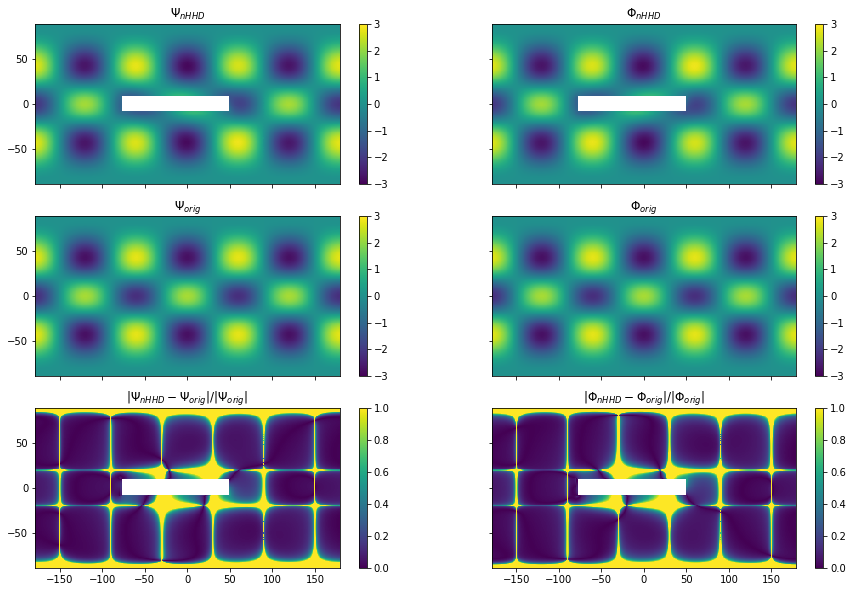

In [5]:
##################################
# TEST 2 - MASKED ARRAY
#
mask=np.ones(psi.shape)
#mask[80:110,100:300]=np.nan
mask[80:100,100:230]=np.nan
#mask[60:120,80:100]=np.nan
psi2 = psi #*mask
phi2 = phi #*mask
#
r2 = gradient(psi2, lat, lon,[dlat,dlon], r=r, rotated=True, glob=True)
d2 = gradient(phi2, lat, lon,[dlat,dlon], r=r, rotated=False, glob=True)
#
U2 = (r2[:,:,0]+d2[:,:,0])*mask
V2 = (r2[:,:,1]+d2[:,:,1])*mask
U2[np.where(np.isnan(U2))]=0
V2[np.where(np.isnan(V2))]=0
#
vfield2 = np.stack([U2,V2],axis=-1)
nhhd2 = nHHD(sphericalgrid=vfield2[:,:,0].shape,spacings=(dlat,dlon),lat=lat,lon=lon,glob=True)
nhhd2.decompose(vfield2,num_cores=10)
#
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(15,10))
ranges=[3,3,3,3]
titles=['$\Psi_{nHHD}$','$\Phi_{nHHD}$','$\Psi_{orig}$','$\Phi_{orig}$','$|\Psi_{nHHD}-\Psi_{orig}|/|\Psi_{orig}|$','$|\Phi_{nHHD}-\Phi_{orig}|/|\Phi_{orig}|$']
ttls=[]
for v,var in enumerate([-nhhd2.nRu/1E6,-nhhd2.nD/1E6,psi2/1E6,phi2/1E6,abs(-nhhd2.nRu-psi2)/abs(psi2),abs((-nhhd2.nD-phi2))/abs(phi2)]):
    if v<4:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=-ranges[v],vmax=ranges[v])
    else:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=0,vmax=1)
    ttl=axes.flatten()[v].set_title(titles[v])
    ttls.append(ttl)
    plt.colorbar(mappable=cm1,ax=axes.flatten()[v])

if savefigs:
    plt.savefig(plotpath+'pynhhd_spherical_test_Fig2.png',format='png',dpi=200,bbox_inches='tight',bbox_extra_artists=ttls)

     Computing gradient...
True (1.0, 1.0) 6371000.0
nan nan
 Done!


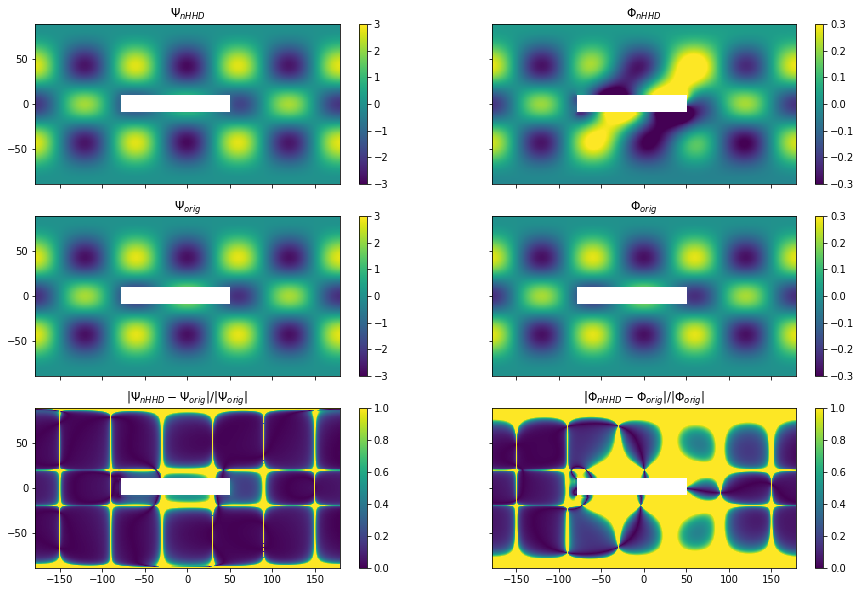

In [6]:
##################################################
# TEST 3 - MASK WITH WEAK PSI
#
mask=np.ones(psi.shape)
mask[80:100,100:230]=np.nan
#
psi3 = psi*mask
phi3 = 0.1*phi*mask
#
r3 = gradient(psi3, lat, lon,[dlat,dlon], r=r, rotated=True, glob=True)
d3 = gradient(phi3, lat, lon,[dlat,dlon], r=r, rotated=False, glob=True)
#
U3 = r3[:,:,0]+d3[:,:,0]
V3 = r3[:,:,1]+d3[:,:,1]
U3[np.where(np.isnan(U3))]=0
V3[np.where(np.isnan(V3))]=0
# 
vfield3 = np.stack([U3,V3],axis=-1)
nhhd3 = nHHD(sphericalgrid=vfield3[:,:,0].shape,spacings=(dlat,dlon),lat=lat,lon=lon,glob=True)
nhhd3.decompose(vfield3,num_cores=10)
#
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(15,10))
ranges=[3,0.3,3,0.3]
titles=['$\Psi_{nHHD}$','$\Phi_{nHHD}$','$\Psi_{orig}$','$\Phi_{orig}$','$|\Psi_{nHHD}-\Psi_{orig}|/|\Psi_{orig}|$','$|\Phi_{nHHD}-\Phi_{orig}|/|\Phi_{orig}|$']
ttls=[]
for v,var in enumerate([-nhhd3.nRu/1E6,-nhhd3.nD/1E6,psi3/1E6,phi3/1E6,abs(-nhhd3.nRu-psi3)/abs(psi3),abs((-nhhd3.nD-phi3))/abs(phi3)]):
    if v<4:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=-ranges[v],vmax=ranges[v])
    else:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=0,vmax=1)
    ttl=axes.flatten()[v].set_title(titles[v])
    ttls.append(ttl)
    plt.colorbar(mappable=cm1,ax=axes.flatten()[v])

if savefigs:
    plt.savefig(plotpath+'pynhhd_spherical_test_Fig3.png',format='png',dpi=200,bbox_inches='tight',bbox_extra_artists=ttls)
    

     Computing gradient...
True (1.0, 1.0) 6371000.0
nan nan
 Done!


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


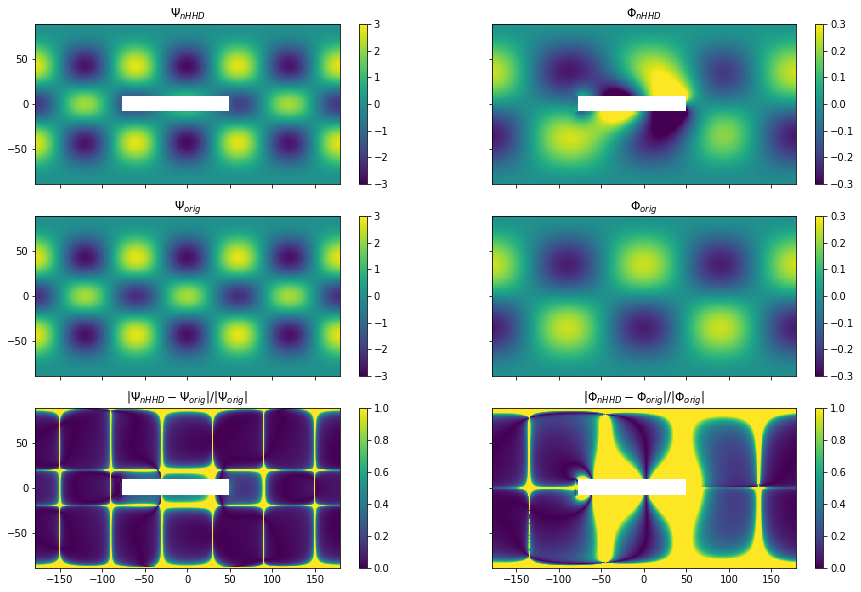

In [7]:
####################################################
# TEST 4
#
mask=np.ones(psi.shape)
mask[80:100,100:230]=np.nan
#
psi4 = r*np.real(sph_harm(3,5,np.radians(lon2),np.radians(lat2[::-1]))) # stream function 
phi4 = 0.1*r*np.real(sph_harm(2,3,np.radians(lon2),np.radians(lat2[::-1]))) # velocity potential
#
r4 = gradient(psi4, lat, lon,[dlat,dlon], r=r, rotated=True, glob=True)
d4 = gradient(phi4, lat, lon,[dlat,dlon], r=r, rotated=False, glob=True)
#
U4 = (r4[:,:,0]+d4[:,:,0])*mask
V4 = (r4[:,:,1]+d4[:,:,1])*mask
U4[np.where(np.isnan(U4))]=0
V4[np.where(np.isnan(V4))]=0
#
vfield4 = np.stack([U4,V4],axis=-1)
nhhd4 = nHHD(sphericalgrid=vfield4[:,:,0].shape,spacings=(dlat,dlon),lat=lat,lon=lon,glob=True)
nhhd4.decompose(vfield4,num_cores=10)
#
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=True,figsize=(15,10))
ranges=[3,0.3,3,0.3]
titles=['$\Psi_{nHHD}$','$\Phi_{nHHD}$','$\Psi_{orig}$','$\Phi_{orig}$','$|\Psi_{nHHD}-\Psi_{orig}|/|\Psi_{orig}|$','$|\Phi_{nHHD}-\Phi_{orig}|/|\Phi_{orig}|$']
ttls=[]
for v,var in enumerate([-nhhd4.nRu/1E6,-nhhd4.nD/1E6,psi4/1E6,phi4/1E6,abs(-nhhd4.nRu-psi4)/abs(psi4),abs((-nhhd4.nD-phi4))/abs(phi4)]):
    if v<4:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=-ranges[v],vmax=ranges[v])
    else:
        cm1=axes.flatten()[v].pcolormesh(lon,lat,var,vmin=0,vmax=1)
    ttl=axes.flatten()[v].set_title(titles[v])
    ttls.append(ttl)
    plt.colorbar(mappable=cm1,ax=axes.flatten()[v])

if savefigs:
    plt.savefig(plotpath+'pynhhd_spherical_test_Fig4.png',format='png',dpi=200,bbox_inches='tight',bbox_extra_artists=ttls)